## 0 - Import useful libraries

In [1]:
# - Get the neccessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
%matplotlib inline
%autosave 60 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Autosaving every 60 seconds
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/sample_submission.csv


## 1 - Load dataset

In [2]:
train_data = pd.read_csv("../input/digit-recognizer/train.csv")
print(train_data.shape)
train_data.head()

(42000, 785)


label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [3]:
test_data = pd.read_csv("../input/digit-recognizer/test.csv")
print(test_data.shape)
test_data.head()

(28000, 784)


pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 784 columns]

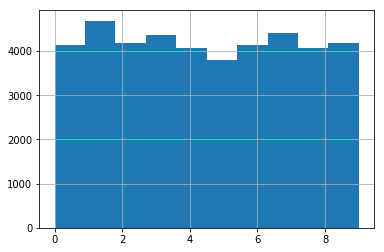

In [4]:
# - explore the label
train_data['label'].hist()

The distribution of the digits is evenly sampled.

In [5]:
# - separates the data into pixel and label array
X = (train_data.iloc[:,1:].values).astype('float32') # Pixel values
y = train_data.iloc[:,0].values.astype('int32') # labels
test_data = test_data.values.astype('float32')

In [6]:
X.shape

(42000, 784)

In [7]:
y.shape

(42000,)

In [8]:
y.shape

(42000,)

## 2 - Data visualization

In [9]:
#Convert pixel from 1D to 2D shape 
N = 28 #size of images
X = X.reshape(X.shape[0], N, N,1) # to fit Keras requiremnet
test_data = test_data.reshape(test_data.shape[0], N, N,1)
X.shape

(42000, 28, 28, 1)

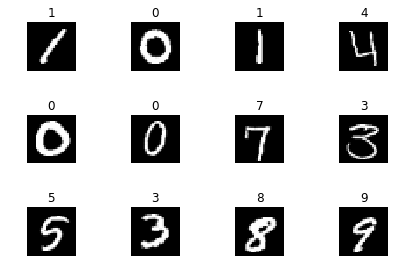

In [10]:
# Visualize the first 12 digits
for i in range(0, 12):
    plt.subplot(3,4,i+1)
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.title(y[i].squeeze());
    plt.axis('off')
plt.tight_layout()

> ## 3 - Data preprocessing

In [11]:
# Feature Standardization
mean_x = X.mean().astype(np.float32)
std_x = X.std().astype(np.float32)
def standardize(x): 
    global mean_x,std_x
    standard_x = (x-mean_x)/std_x
    return standard_x

In [12]:
# One Hot encoding of labels
from keras.utils.np_utils import to_categorical
y = to_categorical(y)

Using TensorFlow backend.


In [13]:
y.shape

(42000, 10)

In [14]:
# split X in to training and validation
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)

In [15]:
# Create more images with data aumentation
data_generator = image.ImageDataGenerator(rotation_range= 10,  zoom_range = 0.10, width_shift_range=0.1, height_shift_range=0.1)
train_batches = data_generator.flow(X_train, y_train, batch_size=64)
val_batches = data_generator.flow(X_val, y_val, batch_size=64)

In [16]:
X_train.shape

(37800, 28, 28, 1)

In [17]:
X_val.shape

(4200, 28, 28, 1)

## 4 - Model setup

In [18]:
# import useful keras libraries
from keras.models import  Sequential
from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D
from keras.optimizers import Adam

In [19]:
# define a function with a CNN model
def DigitClassifierFunction():
    DigitClassifier = Sequential([
        Lambda(standardize, input_shape=(28,28,1)), # input
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        # --
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        # --
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        # --
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
        ])
    # -- Complier DigitClassifier
    DigitClassifier.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return DigitClassifier

In [20]:
DigitClassifier= DigitClassifierFunction()
# - run model for 1 epochs
DigitClassifier_history=DigitClassifier.fit_generator(generator=train_batches, steps_per_epoch=train_batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
36566/37800 [============================>.] - ETA: 2:14 - loss: 0.0391 - accuracy: 0.9888

## 5 - Run model with All data

In [21]:
All_data = data_generator.flow(X, y, batch_size=64)
DigitClassifier_history=DigitClassifier.fit_generator(generator=All_data, steps_per_epoch=All_data.n, epochs=3)

Epoch 1/3
42000/42000 [==============================] - 4718s 112ms/step - loss: 0.0148 - accuracy: 0.9969


## 6 - Submission

In [22]:
predictions = DigitClassifier.predict_classes(test_data, verbose=0)
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("PredictionFile.csv", index=False, header=True)